In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train
VOCAB_SIZE = 3000
EMBEDDING_SIZE = 10
BATCH_SIZE = 128
EPOCH = 20
WINDOW_SIZE = 1
# display number
DISNUM = 50

# name
name = 'fnn2-' + 'epo' + str(EPOCH) + 'ebd' + str(EMBEDDING_SIZE) + 'vcb' + str(VOCAB_SIZE) + 'win' + str(WINDOW_SIZE)

In [12]:
class FNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(FNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
    def forward(self, inputs):
        embedding = self.embedding(inputs)
        out = F.relu(self.fc1(embedding))
        out = self.fc2(out)
        return F.log_softmax(out, dim=-1)

In [13]:
# read corpus from file
corpus = []
with open('news2-cleaned.txt', 'r', encoding='utf-8') as f:
    for line in f:
        corpus.append(line.strip().split(' '))
# build word_to_ix
word_to_ix = {}
for sentence in corpus:
    for word in sentence:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
word_to_ix = {k: v if v < VOCAB_SIZE else VOCAB_SIZE for k, v in word_to_ix.items()}
word_to_ix['<UNK>'] = VOCAB_SIZE

In [14]:
inputs = []
targets = []
for sentence in corpus:
    input_sentence = [word_to_ix.get(word, VOCAB_SIZE) for word in sentence[:-1]]
    target_sentence = [word_to_ix.get(word, VOCAB_SIZE) for word in sentence[1:]]
    inputs.append(torch.tensor(input_sentence, dtype=torch.long))
    targets.append(torch.tensor(target_sentence, dtype=torch.long))

In [15]:
# train model, inputs are single words and targets are their contexts
model = FNN(VOCAB_SIZE+1, EMBEDDING_SIZE, 128)
model.to(device)
loss_function = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(EPOCH):
    total_loss = 0
    for i in tqdm.tqdm(range(0, len(corpus), BATCH_SIZE)):
        input = inputs[i:i+BATCH_SIZE]
        target = targets[i:i+BATCH_SIZE]
        model_input = pad_sequence(input, batch_first=True)
        model_target = pad_sequence(target, batch_first=True)
        model_input = model_input.to(device)
        model_target = model_target.to(device)
        model.zero_grad()
        log_probs = model(model_input)
        loss = loss_function(log_probs.view(-1, VOCAB_SIZE+1), model_target.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('Epoch:', epoch, 'Loss:', total_loss)
word_vectors = np.array(model.embedding.weight.data.cpu())

100%|██████████| 2746/2746 [00:29<00:00, 93.69it/s] 


Epoch: 0 Loss: 3886.7021636664867


100%|██████████| 2746/2746 [00:29<00:00, 94.35it/s] 


Epoch: 1 Loss: 3454.233201265335


100%|██████████| 2746/2746 [00:28<00:00, 95.78it/s] 


Epoch: 2 Loss: 3399.0159783661366


100%|██████████| 2746/2746 [00:28<00:00, 95.74it/s] 


Epoch: 3 Loss: 3372.4033358693123


100%|██████████| 2746/2746 [00:28<00:00, 95.62it/s] 


Epoch: 4 Loss: 3355.852269411087


100%|██████████| 2746/2746 [00:28<00:00, 95.90it/s] 


Epoch: 5 Loss: 3344.2098442316055


100%|██████████| 2746/2746 [00:28<00:00, 95.66it/s] 


Epoch: 6 Loss: 3335.4199548363686


100%|██████████| 2746/2746 [00:28<00:00, 95.47it/s] 


Epoch: 7 Loss: 3328.408067435026


100%|██████████| 2746/2746 [00:28<00:00, 95.52it/s] 


Epoch: 8 Loss: 3322.669601380825


100%|██████████| 2746/2746 [00:28<00:00, 95.60it/s] 


Epoch: 9 Loss: 3317.824379891157


100%|██████████| 2746/2746 [00:28<00:00, 95.58it/s] 


Epoch: 10 Loss: 3313.598229378462


100%|██████████| 2746/2746 [00:28<00:00, 95.49it/s] 


Epoch: 11 Loss: 3310.035615772009


100%|██████████| 2746/2746 [00:28<00:00, 95.53it/s] 


Epoch: 12 Loss: 3306.749278962612


100%|██████████| 2746/2746 [00:28<00:00, 95.26it/s] 


Epoch: 13 Loss: 3303.8604967594147


100%|██████████| 2746/2746 [00:28<00:00, 95.23it/s] 


Epoch: 14 Loss: 3301.3739716410637


100%|██████████| 2746/2746 [00:28<00:00, 95.28it/s] 


Epoch: 15 Loss: 3298.9455742836


100%|██████████| 2746/2746 [00:28<00:00, 95.42it/s] 


Epoch: 16 Loss: 3296.6380246281624


100%|██████████| 2746/2746 [00:29<00:00, 94.45it/s] 


Epoch: 17 Loss: 3294.5689720511436


100%|██████████| 2746/2746 [00:28<00:00, 95.13it/s] 


Epoch: 18 Loss: 3292.773474216461


100%|██████████| 2746/2746 [00:28<00:00, 95.18it/s] 

Epoch: 19 Loss: 3290.9844453036785


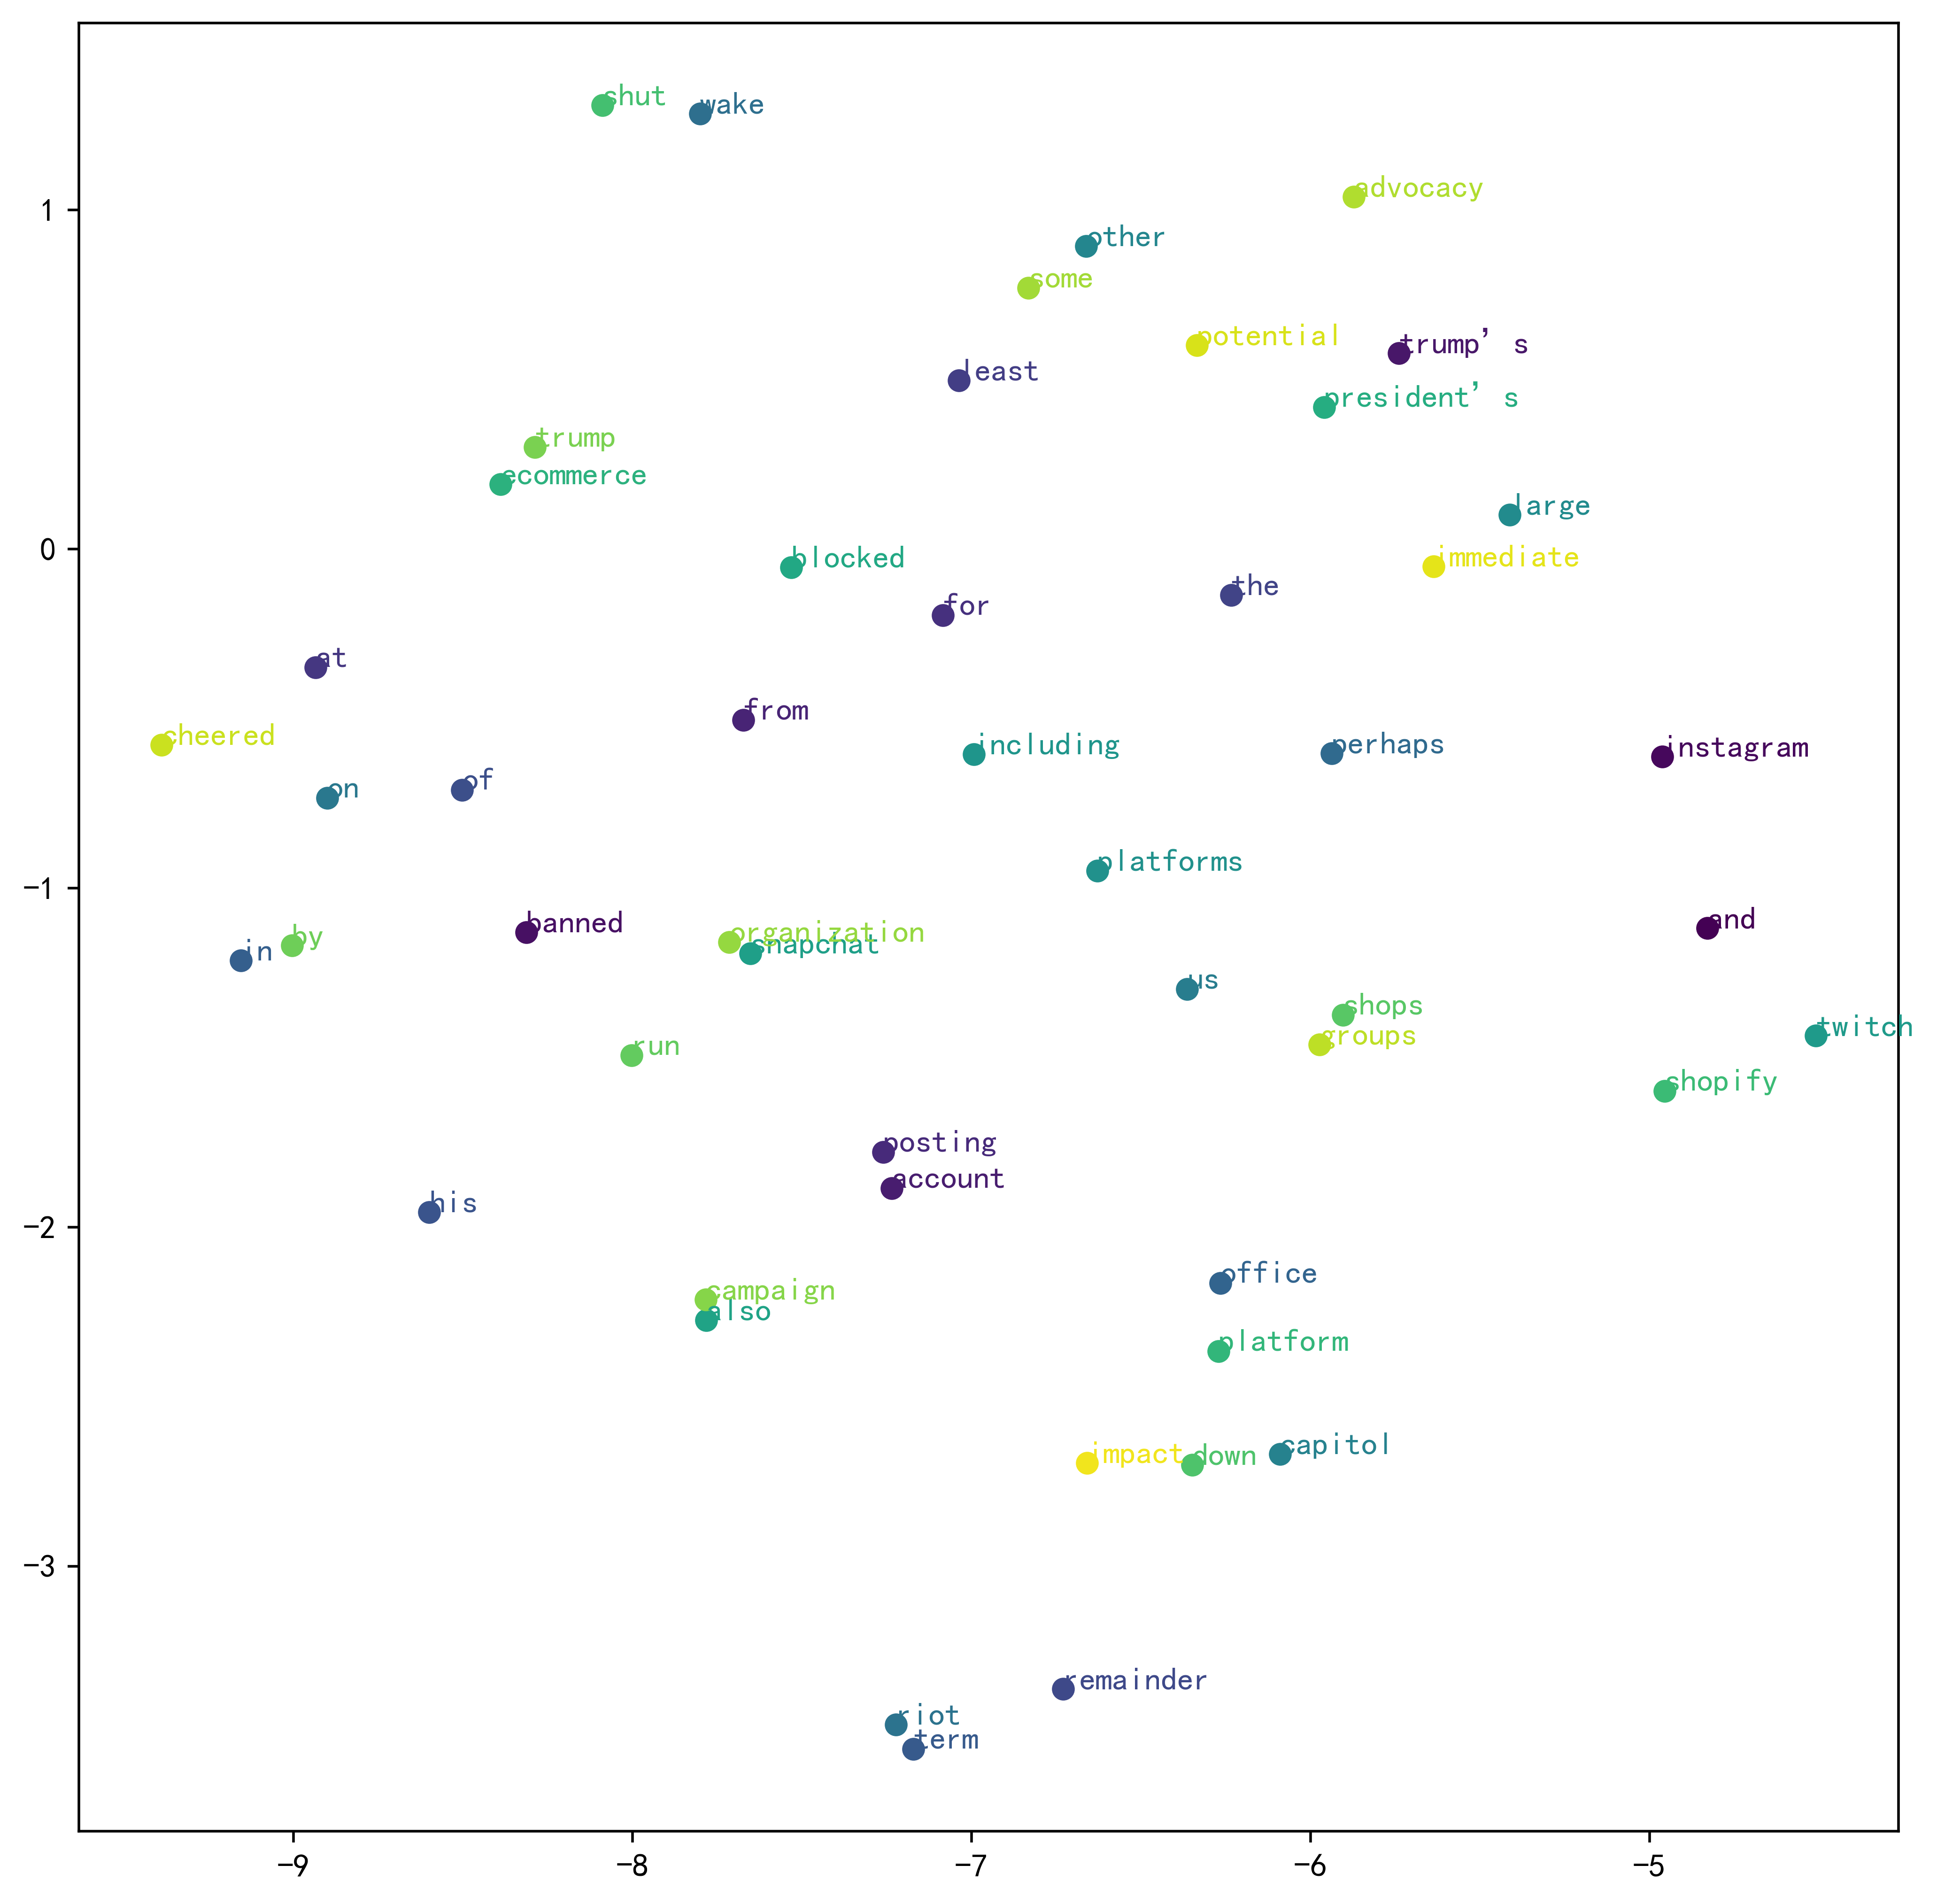

In [16]:
# tsne
tsne = TSNE(n_components=2, random_state=0)
word_vectors_tsne = tsne.fit_transform(word_vectors[:DISNUM])

# plot
plt.rcParams['font.sans-serif'] = ['SimHei']  #显示中文
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
fig, ax = plt.subplots(figsize=(10, 10), dpi=500)

cmap = plt.get_cmap('viridis')
# cmap = plt.get_cmap('tab10')
for i, word in enumerate(word_to_ix):
    if i == DISNUM:
        break
    color = cmap(i/DISNUM)
    ax.scatter(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1], color=color)
    ax.annotate(word, xy=(word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), color=color)
plt.savefig(name + '.png')
torch.save(model.state_dict(), name + '.pth')

In [17]:
import pandas as pd
import os
word_list = list(word_to_ix.keys())[::10][:20]
# get similar words using cosine similarity
def get_similar_words(word, n=10):
    if word not in word_to_ix:
        print('Word not in vocabulary')
        return
    word_vector = word_vectors[word_to_ix[word]]
    similarities = np.dot(word_vectors, word_vector) / (np.linalg.norm(word_vectors, axis=1) * np.linalg.norm(word_vector))
    sorted_indices = np.argsort(similarities)[::-1][1:n+1]
    similar_words = []
    similarity_scores = []
    for i in sorted_indices:
        similar_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(i)]
        similarity = similarities[i]
        similar_words.append(similar_word)
        similarity_scores.append(similarity)
    df = pd.DataFrame({'Similar Words': similar_words, 'Similarity Scores': similarity_scores})
    if not os.path.exists(name):
        os.makedirs(name)
    df.to_excel(f'{name}/{name}_{word}.xlsx', index=False)
for word in word_list:
    get_similar_words(word)